In [163]:
import keras
import tensorflow as tf

In [164]:
# Laplacian filter
L = tf.constant(
    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]], dtype=tf.float32)
L = tf.reshape(L, [3,3,1,1])

# Definition of the LOSS
def f_obj(rho, W):
    @keras.saving.register_keras_serializable()
    def loss(div_u, p_t):
        # laplacian of pressure
        lap_p = tf.nn.convolution(p_t, L, padding="SAME")

        # Computing objective
        diff = tf.math.squared_difference(div_u, 1/rho * lap_p)
        # obj = tf.math.reduce_sum(tf.math.multiply(W, diff))
        obj = tf.math.reduce_sum(diff)
        return obj
    return loss
custom_loss = f_obj(1,1)

In [165]:
import os

path_model = "./4_pressure_solution_NET/"
filename="SAVED_MODEL.keras"
if os.path.exists(path_model):
    # Load back the model
    model = keras.models.load_model(path_model+filename)
else:
    os.makedirs(path_model)


# Simulate of a feedforward
Check if system is able to produce solenoidal vector field U
- evaluate the need to use smooth fields (uncorrelated, though) for the velocity field components

In [166]:
# std is 1.
# The dataset has been trained with std to be 0.2
import matplotlib.pyplot as plt
import numpy as np
from myPackageUtils.spatial_filter import spatial_filter

    
N_x, N_y = (128, 128)
random_noise1 = np.random.normal(size=(N_x, N_y))
random_noise2 = np.random.normal(size=(N_x, N_y))

u_ast_num = spatial_filter(random_noise1, char_len=5).astype(np.double)
v_ast_num = spatial_filter(random_noise2, char_len=5).astype(np.double)


/tmp/ipykernel_1793/2409178353.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  u_ast_num = spatial_filter(random_noise1, char_len=5).astype(np.double)
/tmp/ipykernel_1793/2409178353.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  v_ast_num = spatial_filter(random_noise2, char_len=5).astype(np.double)


Text(0.5, 1.0, '')

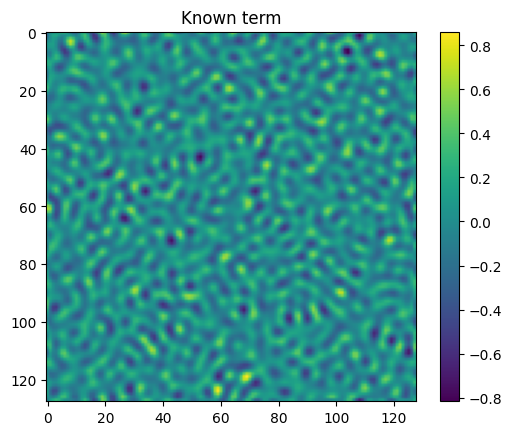

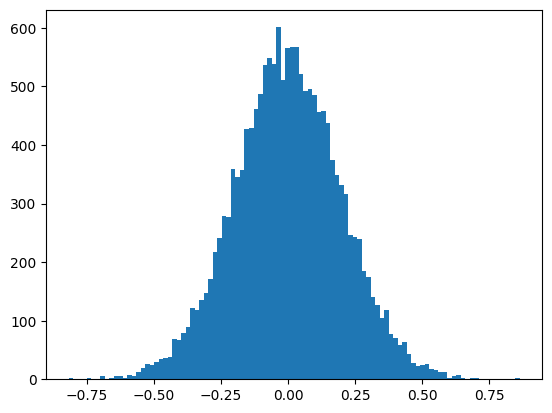

In [167]:
u_ast = tf.constant(u_ast_num.reshape((1,N_x, N_y,1)), dtype=tf.float32)
v_ast = tf.constant(v_ast_num.reshape((1,N_x, N_y,1)), dtype=tf.float32)

# Define the derivative templates
D_x = 0.5 * tf.constant(
    [[0., -1., 0.],
    [0., 0., 0.],
    [0., 1., 0.]]
)
D_x = tf.reshape(D_x, [3,3,1,1])
D_y = 0.5 * tf.constant(
    [[0., 0., 0.],
    [-1., 0., 1.],
    [0., 0., 0.]]
)
D_y = tf.reshape(D_y, [3,3,1,1])

div_u = (tf.nn.convolution(u_ast, D_x, padding="SAME") + tf.nn.convolution(v_ast, D_y, padding="SAME"))

# normalize the input
div_u_std = tf.math.reduce_std(div_u)
scaling_factor = (0.2 * 1/div_u_std)
b = scaling_factor * div_u

# let us plot and check data structure
plt.figure()
plt.imshow(b[0,:,:,0])
plt.title("Known term")
plt.colorbar()

plt.figure()
plt.hist(b[0,:,:,0].numpy().flatten(), bins=100)
plt.title("")

# p_out = model(b)

# Compute feedforward

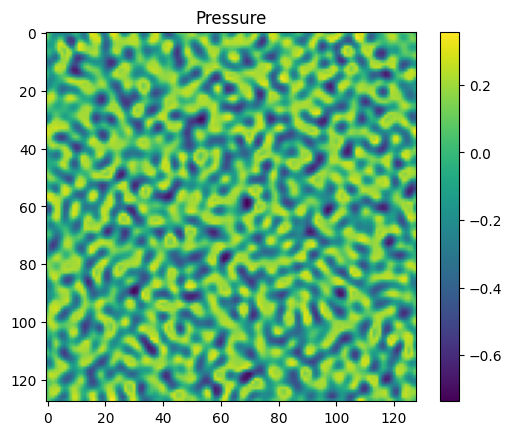

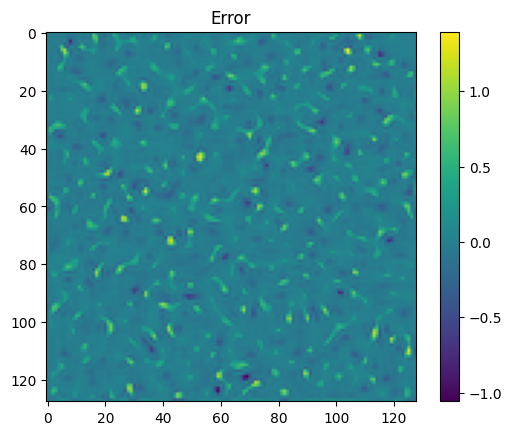

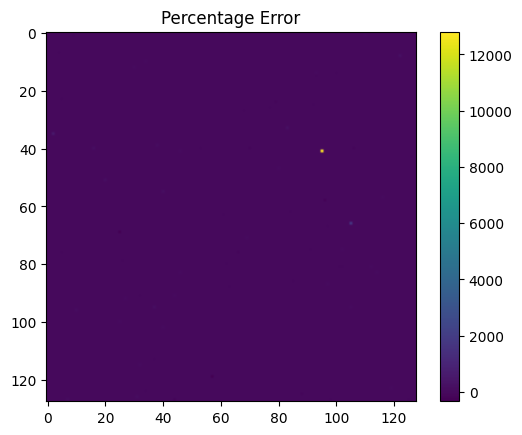

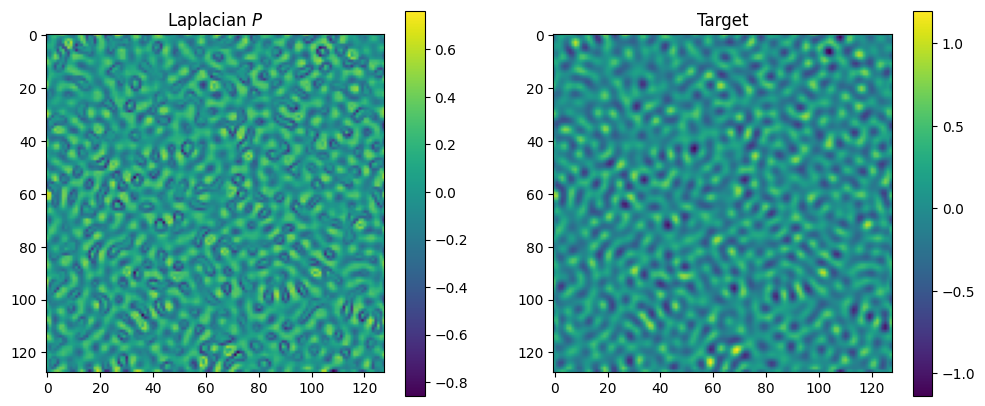

In [168]:
p_out = model(b)
# Denormalize
p_out = p_out * (scaling_factor**-1)
lap_p = tf.nn.convolution(p_out, L, padding="SAME")

# ---- PLOT SECTION ---- #
plt.figure()
plt.imshow(p_out[0,:,:,0])
plt.title("Pressure")
plt.colorbar()
# First figure
plt.figure()
plt.imshow( lap_p[0,:,:,0] - div_u[0,:,:,0] ) 
plt.title("Error")
plt.colorbar()

plt.figure()
plt.imshow( tf.divide((lap_p[0,:,:,0] - div_u[0,:,:,0]), div_u[0,:,:,0]) )
plt.title("Percentage Error")
plt.colorbar()
# Second figure
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow( lap_p[0,:,:,0])
plt.title("Laplacian $P$")
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Target")
plt.imshow( div_u[0,:,:,0])
plt.colorbar()
# plt.imshow(t1[0,:,:,0])
# ---- PLOT SECTION ---- 

# Denormalize the pressure by the scaling factor
Use it also for making the field soleinodal:
$ u_{t} = u_{t-1} - \nabla p$

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 3.000e+00, 7.000e+00, 9.000e+00, 9.000e+00,
        1.000e+01, 6.000e+00, 1.000e+01, 1.200e+01, 1.700e+01, 1.500e+01,
        2.700e+01, 1.800e+01, 2.300e+01, 2.700e+01, 2.500e+01, 3.100e+01,
        4.800e+01, 4.700e+01, 4.400e+01, 5.700e+01, 7.000e+01, 8.000e+01,
        8.200e+01, 1.240e+02, 1.340e+02, 1.090e+02, 1.490e+02, 1.590e+02,
        1.700e+02, 1.850e+02, 2.390e+02, 3.370e+02, 4.300e+02, 6.260e+02,
        8.290e+02, 1.073e+03, 1.390e+03, 1.511e+03, 1.530e+03, 1.438e+03,
        1.220e+03, 9.850e+02, 7.580e+02, 5.310e+02, 4.200e+02, 2.940e+02,
        2.420e+02, 1.730e+02, 1.580e+02, 1.070e+02, 8.700e+01, 6.300e+01,
        5.000e+01, 2.900e+01, 3.300e+01, 1.800e+01, 1.700e+01, 1.300e+01,
        6.000e+00, 4.000e+00, 1.100e+0

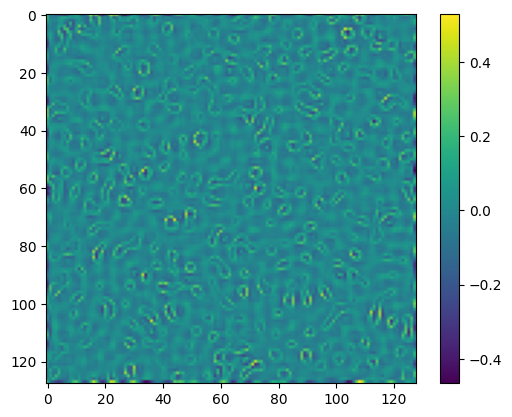

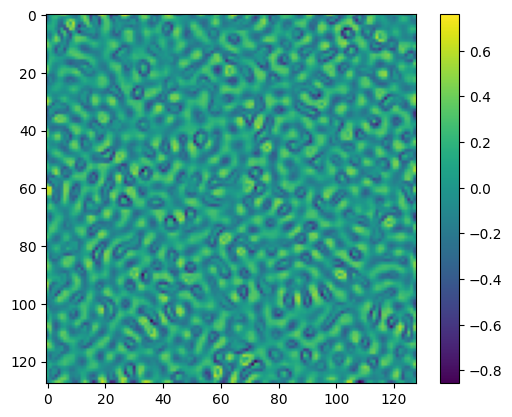

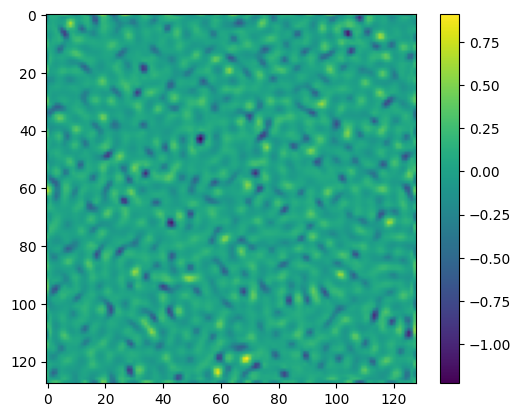

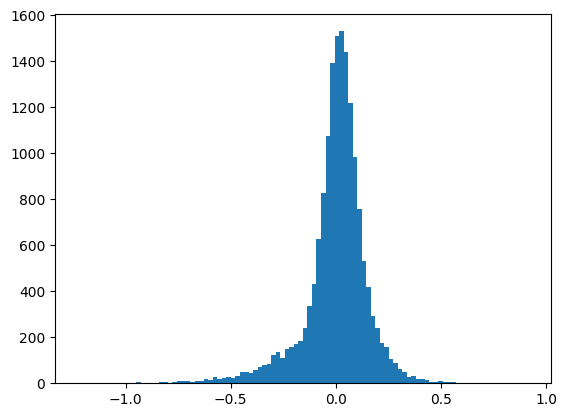

In [169]:
u = u_ast - tf.nn.convolution(p_out, D_x, padding="SAME")
v = v_ast - tf.nn.convolution(p_out, D_y, padding="SAME")

p_x = tf.nn.convolution(p_out, D_x, padding="SAME")
p_y = tf.nn.convolution(p_out, D_y, padding="SAME")
lap_p_wrong = (tf.nn.convolution(p_x, D_x, padding="SAME") + 
               tf.nn.convolution(p_y, D_y, padding="SAME"))

plt.figure()
plt.imshow(lap_p_wrong[0,:,:,0] - lap_p[0,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(lap_p[0,:,:,0])
plt.colorbar()

# Compute diverge of u
div_u_new = (tf.nn.convolution(u, D_x, padding="SAME") + tf.nn.convolution(v, D_y, padding="SAME"))

plt.figure()
plt.imshow(div_u_new[0,:,:,0])
plt.colorbar()
plt.figure()
plt.hist(div_u_new[0,:,:,0].numpy().flatten(), bins=100)